In [2]:
import os
import keras
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.optimizers import Adam, Nadam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [3]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf

from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
t_start = time.time()

In [4]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.7)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [5]:
# Set some parameters
im_width = 256
im_height = 256
border = 5
path_train = "C:/Users/yousu/Downloads/BlastsOnline"

In [6]:
# Get and resize train images and masks
def get_data(path, train=True):
    ids = next(os.walk(path + "/imagesResized_256_1368_updated"))[2]
    ids2= next(os.walk(path + "/labelResized_256_1368_updated"))[2]
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids2), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path + '/imagesResized_256_1368_updated/' + id_, grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (im_width, im_height, 1), mode='constant', preserve_range=True)
        X[n] = x_img / 255

    for n, id_ in tqdm_notebook(enumerate(ids2), total=len(ids2)):
        # Load masks
        if train:
            mask = img_to_array(load_img(path + '/labelResized_256_1368_updated/' + id_, grayscale=True))
            mask = resize(mask, (im_width, im_height, 1), mode='constant', preserve_range=True)
            y[n] = mask / 255

        # Save images
        #X[n] = x_img / 255
        #if train:
            #y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(path_train, train=True)

Getting and resizing images ... 


c:\users\yousu\appdata\local\programs\python\python36\lib\site-packages\keras_preprocessing\image\utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



Done!


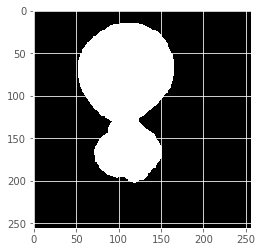

In [7]:
first_image = y[114]
first_image = np.array(first_image)
pixels = first_image.reshape((im_width, im_height))
plt.imshow(pixels, cmap='gray')
plt.show()

In [7]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=2018)

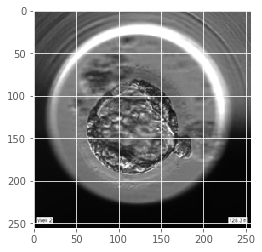

342


In [9]:
first_image = X_train[58]
first_image = np.array(first_image)
pixels = first_image.reshape((im_width, im_height))
plt.imshow(pixels, cmap='gray')
plt.show()
print(len(y_valid))

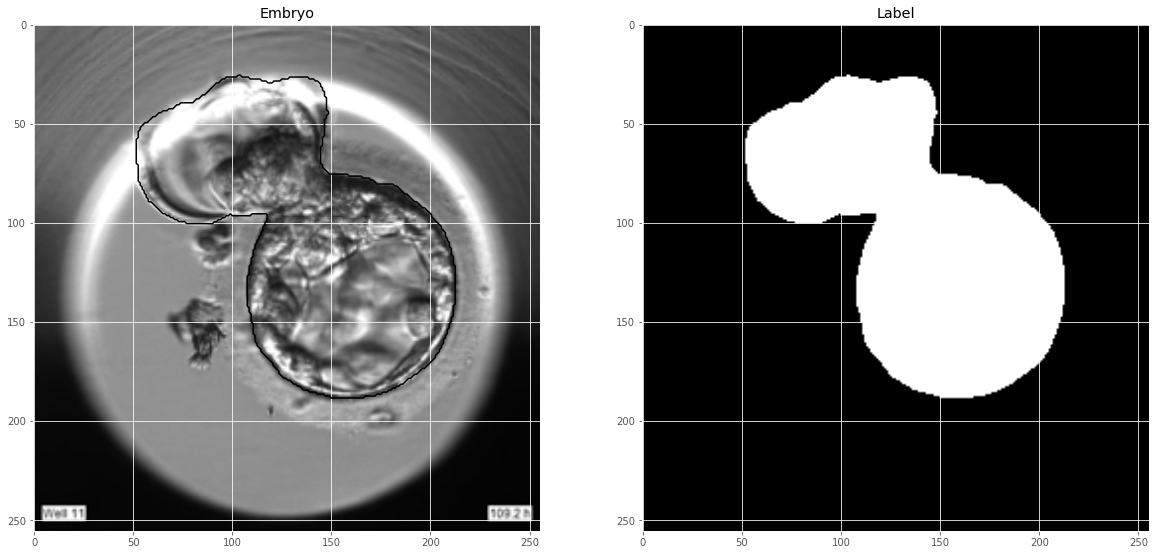

In [10]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix,...,0], cmap='gray', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Embryo')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Label');
#print(ix)

In [8]:
from segmentation_models import Unet
#from segmentation_models.backbones import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

Segmentation Models: using `keras` framework.


In [9]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    #Third Layer
    #x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               #padding="same")(x)
    #if batchnorm:
        #x = BatchNormalization()(x)
    #x = Activation("relu")(x)
    return x

In [10]:
def get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    #c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    #u6 = BatchNormalization()(u6) # added by me
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (2, 2), strides=(2, 2), padding='same') (c4)
    u7 = concatenate([u7, c3])
    #u7 = BatchNormalization()(u7) 
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    #u8 = BatchNormalization()(u8)
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    #u9 = BatchNormalization()(u9)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [11]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
lr=0.0001
model.compile(optimizer=Nadam(lr), loss=bce_jaccard_loss, metrics=[iou_score])
model.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 16) 0           batch_normalization_1[0][0]    

In [15]:
def show_flipped_images(x):
    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(x[:,:,0], cmap='gray')
    ax[0].set_title('original')
    ax[1].imshow(np.fliplr(x[:,:,0]), cmap='gray')
    ax[2].imshow(np.flipud(x[:,:,0]), cmap='gray')
    ax[3].imshow(np.fliplr(np.flipud(x[:,:,0])), cmap='gray')

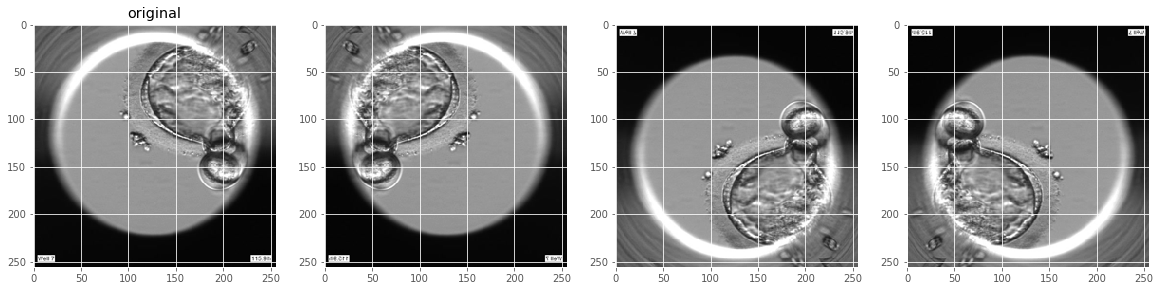

In [16]:
show_flipped_images(X_train[54])

In [14]:
data_gen_args = dict(horizontal_flip=True,
                    vertical_flip=True,
                    rotation_range=270,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    zoom_range=0.1)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 2018
bs = 16 #batchsize

image_generator = image_datagen.flow(X_train, seed=seed, batch_size=bs, shuffle=True)
mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=bs, shuffle=True)

# Just zip the two generators to get a generator that provides augmented images and masks at the same time
train_generator = zip(image_generator, mask_generator)

In [13]:
NAME = "UNET_MOD01-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [14]:
callbacks = [
    EarlyStopping(patience=15, verbose=1),
    ReduceLROnPlateau(factor=0.05, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('model-Unetplus_01.h5', verbose=1, save_best_only=True, save_weights_only=True),
    tensorboard
]

In [15]:
results = model.fit_generator(train_generator, steps_per_epoch=(len(X_train) // bs), epochs=100, callbacks=callbacks,
                              validation_data=(X_valid, y_valid))




Epoch 1/100
64/64 [==============================] - ETA: 4:04 - loss: 1.6359 - iou_score: 0.190 - ETA: 2:06 - loss: 1.6386 - iou_score: 0.185 - ETA: 1:26 - loss: 1.6325 - iou_score: 0.187 - ETA: 1:07 - loss: 1.6283 - iou_score: 0.187 - ETA: 55s - loss: 1.6211 - iou_score: 0.187 - ETA: 47s - loss: 1.6152 - iou_score: 0.18 - ETA: 41s - loss: 1.6066 - iou_score: 0.19 - ETA: 36s - loss: 1.6022 - iou_score: 0.19 - ETA: 33s - loss: 1.5976 - iou_score: 0.19 - ETA: 30s - loss: 1.5897 - iou_score: 0.19 - ETA: 28s - loss: 1.5837 - iou_score: 0.19 - ETA: 26s - loss: 1.5797 - iou_score: 0.19 - ETA: 24s - loss: 1.5726 - iou_score: 0.19 - ETA: 23s - loss: 1.5655 - iou_score: 0.20 - ETA: 21s - loss: 1.5589 - iou_score: 0.20 - ETA: 20s - loss: 1.5533 - iou_score: 0.20 - ETA: 19s - loss: 1.5481 - iou_score: 0.20 - ETA: 18s - loss: 1.5432 - iou_score: 0.20 - ETA: 17s - loss: 1.5363 - iou_score: 0.20 - ETA: 16s - loss: 1.5315 - iou_score: 0.20 - ETA: 16s - loss: 1.5262 - iou_score: 0.20 - ETA: 15s - 

64/64 [==============================] - ETA: 11s - loss: 0.7906 - iou_score: 0.47 - ETA: 12s - loss: 0.7717 - iou_score: 0.48 - ETA: 12s - loss: 0.7601 - iou_score: 0.48 - ETA: 10s - loss: 0.7510 - iou_score: 0.49 - ETA: 10s - loss: 0.7485 - iou_score: 0.49 - ETA: 10s - loss: 0.7473 - iou_score: 0.49 - ETA: 10s - loss: 0.7419 - iou_score: 0.49 - ETA: 10s - loss: 0.7404 - iou_score: 0.49 - ETA: 10s - loss: 0.7445 - iou_score: 0.49 - ETA: 10s - loss: 0.7436 - iou_score: 0.49 - ETA: 10s - loss: 0.7434 - iou_score: 0.49 - ETA: 9s - loss: 0.7422 - iou_score: 0.4956 - ETA: 9s - loss: 0.7436 - iou_score: 0.495 - ETA: 9s - loss: 0.7432 - iou_score: 0.495 - ETA: 9s - loss: 0.7415 - iou_score: 0.497 - ETA: 9s - loss: 0.7408 - iou_score: 0.497 - ETA: 9s - loss: 0.7413 - iou_score: 0.497 - ETA: 9s - loss: 0.7409 - iou_score: 0.498 - ETA: 8s - loss: 0.7415 - iou_score: 0.498 - ETA: 8s - loss: 0.7421 - iou_score: 0.497 - ETA: 8s - loss: 0.7430 - iou_score: 0.496 - ETA: 8s - loss: 0.7427 - iou_score

64/64 [==============================] - ETA: 16s - loss: 0.6243 - iou_score: 0.56 - ETA: 16s - loss: 0.6318 - iou_score: 0.55 - ETA: 16s - loss: 0.6209 - iou_score: 0.56 - ETA: 16s - loss: 0.6228 - iou_score: 0.56 - ETA: 15s - loss: 0.6268 - iou_score: 0.55 - ETA: 15s - loss: 0.6316 - iou_score: 0.55 - ETA: 15s - loss: 0.6312 - iou_score: 0.55 - ETA: 13s - loss: 0.6312 - iou_score: 0.55 - ETA: 12s - loss: 0.6307 - iou_score: 0.55 - ETA: 12s - loss: 0.6317 - iou_score: 0.55 - ETA: 12s - loss: 0.6306 - iou_score: 0.55 - ETA: 11s - loss: 0.6300 - iou_score: 0.55 - ETA: 11s - loss: 0.6301 - iou_score: 0.55 - ETA: 11s - loss: 0.6326 - iou_score: 0.55 - ETA: 10s - loss: 0.6315 - iou_score: 0.55 - ETA: 10s - loss: 0.6315 - iou_score: 0.55 - ETA: 10s - loss: 0.6311 - iou_score: 0.55 - ETA: 9s - loss: 0.6301 - iou_score: 0.5601 - ETA: 9s - loss: 0.6301 - iou_score: 0.559 - ETA: 9s - loss: 0.6297 - iou_score: 0.559 - ETA: 9s - loss: 0.6280 - iou_score: 0.560 - ETA: 9s - loss: 0.6275 - iou_score

64/64 [==============================] - ETA: 11s - loss: 0.5361 - iou_score: 0.61 - ETA: 11s - loss: 0.5245 - iou_score: 0.62 - ETA: 11s - loss: 0.5336 - iou_score: 0.61 - ETA: 11s - loss: 0.5377 - iou_score: 0.61 - ETA: 11s - loss: 0.5361 - iou_score: 0.61 - ETA: 11s - loss: 0.5429 - iou_score: 0.60 - ETA: 11s - loss: 0.5416 - iou_score: 0.60 - ETA: 10s - loss: 0.5414 - iou_score: 0.61 - ETA: 10s - loss: 0.5412 - iou_score: 0.61 - ETA: 10s - loss: 0.5417 - iou_score: 0.60 - ETA: 10s - loss: 0.5422 - iou_score: 0.60 - ETA: 9s - loss: 0.5381 - iou_score: 0.6122 - ETA: 9s - loss: 0.5392 - iou_score: 0.611 - ETA: 9s - loss: 0.5403 - iou_score: 0.610 - ETA: 8s - loss: 0.5414 - iou_score: 0.610 - ETA: 8s - loss: 0.5395 - iou_score: 0.611 - ETA: 8s - loss: 0.5416 - iou_score: 0.610 - ETA: 8s - loss: 0.5409 - iou_score: 0.610 - ETA: 8s - loss: 0.5420 - iou_score: 0.610 - ETA: 8s - loss: 0.5414 - iou_score: 0.610 - ETA: 7s - loss: 0.5407 - iou_score: 0.610 - ETA: 7s - loss: 0.5394 - iou_score

64/64 [==============================] - ETA: 12s - loss: 0.5044 - iou_score: 0.63 - ETA: 11s - loss: 0.4937 - iou_score: 0.63 - ETA: 11s - loss: 0.4900 - iou_score: 0.63 - ETA: 11s - loss: 0.4851 - iou_score: 0.64 - ETA: 11s - loss: 0.4799 - iou_score: 0.64 - ETA: 11s - loss: 0.4737 - iou_score: 0.65 - ETA: 11s - loss: 0.4756 - iou_score: 0.65 - ETA: 10s - loss: 0.4726 - iou_score: 0.65 - ETA: 10s - loss: 0.4691 - iou_score: 0.65 - ETA: 10s - loss: 0.4686 - iou_score: 0.65 - ETA: 10s - loss: 0.4656 - iou_score: 0.66 - ETA: 10s - loss: 0.4645 - iou_score: 0.66 - ETA: 9s - loss: 0.4656 - iou_score: 0.6610 - ETA: 9s - loss: 0.4655 - iou_score: 0.660 - ETA: 9s - loss: 0.4644 - iou_score: 0.661 - ETA: 8s - loss: 0.4636 - iou_score: 0.660 - ETA: 8s - loss: 0.4629 - iou_score: 0.661 - ETA: 8s - loss: 0.4619 - iou_score: 0.661 - ETA: 8s - loss: 0.4622 - iou_score: 0.661 - ETA: 8s - loss: 0.4611 - iou_score: 0.662 - ETA: 7s - loss: 0.4611 - iou_score: 0.662 - ETA: 7s - loss: 0.4604 - iou_score

64/64 [==============================] - ETA: 11s - loss: 0.4131 - iou_score: 0.68 - ETA: 11s - loss: 0.4120 - iou_score: 0.69 - ETA: 11s - loss: 0.4242 - iou_score: 0.68 - ETA: 11s - loss: 0.4195 - iou_score: 0.69 - ETA: 11s - loss: 0.4132 - iou_score: 0.69 - ETA: 11s - loss: 0.4072 - iou_score: 0.70 - ETA: 11s - loss: 0.4090 - iou_score: 0.69 - ETA: 10s - loss: 0.4097 - iou_score: 0.69 - ETA: 10s - loss: 0.4078 - iou_score: 0.70 - ETA: 10s - loss: 0.4049 - iou_score: 0.70 - ETA: 10s - loss: 0.4064 - iou_score: 0.70 - ETA: 10s - loss: 0.4039 - iou_score: 0.70 - ETA: 9s - loss: 0.4038 - iou_score: 0.7029 - ETA: 9s - loss: 0.4031 - iou_score: 0.703 - ETA: 9s - loss: 0.4029 - iou_score: 0.703 - ETA: 9s - loss: 0.4031 - iou_score: 0.703 - ETA: 9s - loss: 0.4031 - iou_score: 0.703 - ETA: 8s - loss: 0.4036 - iou_score: 0.702 - ETA: 8s - loss: 0.4028 - iou_score: 0.703 - ETA: 8s - loss: 0.4025 - iou_score: 0.703 - ETA: 7s - loss: 0.4046 - iou_score: 0.702 - ETA: 7s - loss: 0.4051 - iou_score

64/64 [==============================] - ETA: 11s - loss: 0.3621 - iou_score: 0.73 - ETA: 12s - loss: 0.3539 - iou_score: 0.73 - ETA: 11s - loss: 0.3518 - iou_score: 0.73 - ETA: 11s - loss: 0.3523 - iou_score: 0.73 - ETA: 11s - loss: 0.3493 - iou_score: 0.73 - ETA: 11s - loss: 0.3505 - iou_score: 0.73 - ETA: 11s - loss: 0.3458 - iou_score: 0.74 - ETA: 11s - loss: 0.3430 - iou_score: 0.74 - ETA: 10s - loss: 0.3427 - iou_score: 0.74 - ETA: 10s - loss: 0.3440 - iou_score: 0.74 - ETA: 10s - loss: 0.3457 - iou_score: 0.74 - ETA: 10s - loss: 0.3469 - iou_score: 0.74 - ETA: 9s - loss: 0.3473 - iou_score: 0.7398 - ETA: 9s - loss: 0.3482 - iou_score: 0.739 - ETA: 9s - loss: 0.3469 - iou_score: 0.740 - ETA: 9s - loss: 0.3469 - iou_score: 0.740 - ETA: 9s - loss: 0.3457 - iou_score: 0.741 - ETA: 9s - loss: 0.3457 - iou_score: 0.741 - ETA: 8s - loss: 0.3457 - iou_score: 0.741 - ETA: 8s - loss: 0.3460 - iou_score: 0.741 - ETA: 8s - loss: 0.3452 - iou_score: 0.741 - ETA: 8s - loss: 0.3459 - iou_score

64/64 [==============================] - ETA: 11s - loss: 0.2920 - iou_score: 0.78 - ETA: 12s - loss: 0.3223 - iou_score: 0.75 - ETA: 11s - loss: 0.3112 - iou_score: 0.76 - ETA: 11s - loss: 0.3111 - iou_score: 0.76 - ETA: 11s - loss: 0.3087 - iou_score: 0.76 - ETA: 11s - loss: 0.3097 - iou_score: 0.77 - ETA: 11s - loss: 0.3116 - iou_score: 0.76 - ETA: 10s - loss: 0.3110 - iou_score: 0.76 - ETA: 10s - loss: 0.3097 - iou_score: 0.77 - ETA: 10s - loss: 0.3084 - iou_score: 0.77 - ETA: 10s - loss: 0.3082 - iou_score: 0.77 - ETA: 10s - loss: 0.3061 - iou_score: 0.77 - ETA: 9s - loss: 0.3072 - iou_score: 0.7722 - ETA: 9s - loss: 0.3089 - iou_score: 0.771 - ETA: 9s - loss: 0.3082 - iou_score: 0.771 - ETA: 9s - loss: 0.3068 - iou_score: 0.772 - ETA: 9s - loss: 0.3069 - iou_score: 0.772 - ETA: 9s - loss: 0.3069 - iou_score: 0.772 - ETA: 8s - loss: 0.3053 - iou_score: 0.773 - ETA: 8s - loss: 0.3056 - iou_score: 0.773 - ETA: 8s - loss: 0.3054 - iou_score: 0.773 - ETA: 8s - loss: 0.3054 - iou_score

64/64 [==============================] - ETA: 12s - loss: 0.2564 - iou_score: 0.80 - ETA: 12s - loss: 0.2648 - iou_score: 0.80 - ETA: 12s - loss: 0.2731 - iou_score: 0.79 - ETA: 11s - loss: 0.2790 - iou_score: 0.78 - ETA: 11s - loss: 0.2729 - iou_score: 0.79 - ETA: 11s - loss: 0.2722 - iou_score: 0.79 - ETA: 11s - loss: 0.2707 - iou_score: 0.79 - ETA: 10s - loss: 0.2703 - iou_score: 0.79 - ETA: 10s - loss: 0.2715 - iou_score: 0.79 - ETA: 10s - loss: 0.2722 - iou_score: 0.79 - ETA: 10s - loss: 0.2721 - iou_score: 0.79 - ETA: 10s - loss: 0.2710 - iou_score: 0.79 - ETA: 9s - loss: 0.2703 - iou_score: 0.7974 - ETA: 9s - loss: 0.2689 - iou_score: 0.798 - ETA: 9s - loss: 0.2685 - iou_score: 0.799 - ETA: 9s - loss: 0.2698 - iou_score: 0.798 - ETA: 9s - loss: 0.2689 - iou_score: 0.799 - ETA: 9s - loss: 0.2693 - iou_score: 0.798 - ETA: 8s - loss: 0.2689 - iou_score: 0.799 - ETA: 8s - loss: 0.2682 - iou_score: 0.799 - ETA: 8s - loss: 0.2683 - iou_score: 0.800 - ETA: 8s - loss: 0.2687 - iou_score

64/64 [==============================] - ETA: 12s - loss: 0.2521 - iou_score: 0.81 - ETA: 12s - loss: 0.2511 - iou_score: 0.81 - ETA: 11s - loss: 0.2522 - iou_score: 0.81 - ETA: 11s - loss: 0.2466 - iou_score: 0.81 - ETA: 11s - loss: 0.2546 - iou_score: 0.81 - ETA: 11s - loss: 0.2529 - iou_score: 0.81 - ETA: 11s - loss: 0.2517 - iou_score: 0.81 - ETA: 10s - loss: 0.2511 - iou_score: 0.81 - ETA: 10s - loss: 0.2516 - iou_score: 0.81 - ETA: 10s - loss: 0.2499 - iou_score: 0.81 - ETA: 10s - loss: 0.2505 - iou_score: 0.81 - ETA: 10s - loss: 0.2500 - iou_score: 0.81 - ETA: 9s - loss: 0.2488 - iou_score: 0.8162 - ETA: 9s - loss: 0.2495 - iou_score: 0.816 - ETA: 9s - loss: 0.2474 - iou_score: 0.817 - ETA: 9s - loss: 0.2479 - iou_score: 0.818 - ETA: 9s - loss: 0.2473 - iou_score: 0.818 - ETA: 8s - loss: 0.2475 - iou_score: 0.818 - ETA: 8s - loss: 0.2470 - iou_score: 0.818 - ETA: 8s - loss: 0.2463 - iou_score: 0.818 - ETA: 8s - loss: 0.2460 - iou_score: 0.819 - ETA: 8s - loss: 0.2456 - iou_score

64/64 [==============================] - ETA: 11s - loss: 0.2148 - iou_score: 0.83 - ETA: 11s - loss: 0.2035 - iou_score: 0.84 - ETA: 11s - loss: 0.2262 - iou_score: 0.83 - ETA: 11s - loss: 0.2253 - iou_score: 0.83 - ETA: 11s - loss: 0.2224 - iou_score: 0.83 - ETA: 11s - loss: 0.2213 - iou_score: 0.83 - ETA: 10s - loss: 0.2182 - iou_score: 0.83 - ETA: 10s - loss: 0.2190 - iou_score: 0.83 - ETA: 10s - loss: 0.2156 - iou_score: 0.84 - ETA: 10s - loss: 0.2160 - iou_score: 0.83 - ETA: 10s - loss: 0.2160 - iou_score: 0.83 - ETA: 10s - loss: 0.2140 - iou_score: 0.84 - ETA: 10s - loss: 0.2131 - iou_score: 0.84 - ETA: 9s - loss: 0.2119 - iou_score: 0.8431 - ETA: 9s - loss: 0.2124 - iou_score: 0.843 - ETA: 9s - loss: 0.2126 - iou_score: 0.843 - ETA: 9s - loss: 0.2130 - iou_score: 0.842 - ETA: 9s - loss: 0.2136 - iou_score: 0.842 - ETA: 8s - loss: 0.2142 - iou_score: 0.842 - ETA: 8s - loss: 0.2149 - iou_score: 0.841 - ETA: 8s - loss: 0.2146 - iou_score: 0.841 - ETA: 8s - loss: 0.2144 - iou_score

64/64 [==============================] - ETA: 15s - loss: 0.2062 - iou_score: 0.85 - ETA: 15s - loss: 0.2043 - iou_score: 0.85 - ETA: 14s - loss: 0.2165 - iou_score: 0.84 - ETA: 14s - loss: 0.2147 - iou_score: 0.84 - ETA: 14s - loss: 0.2154 - iou_score: 0.84 - ETA: 14s - loss: 0.2124 - iou_score: 0.84 - ETA: 14s - loss: 0.2087 - iou_score: 0.84 - ETA: 13s - loss: 0.2106 - iou_score: 0.84 - ETA: 13s - loss: 0.2075 - iou_score: 0.85 - ETA: 13s - loss: 0.2082 - iou_score: 0.84 - ETA: 12s - loss: 0.2085 - iou_score: 0.84 - ETA: 12s - loss: 0.2063 - iou_score: 0.85 - ETA: 12s - loss: 0.2042 - iou_score: 0.85 - ETA: 12s - loss: 0.2030 - iou_score: 0.85 - ETA: 11s - loss: 0.2032 - iou_score: 0.85 - ETA: 11s - loss: 0.2019 - iou_score: 0.85 - ETA: 10s - loss: 0.2010 - iou_score: 0.85 - ETA: 10s - loss: 0.2002 - iou_score: 0.85 - ETA: 10s - loss: 0.1991 - iou_score: 0.85 - ETA: 10s - loss: 0.1986 - iou_score: 0.85 - ETA: 9s - loss: 0.1977 - iou_score: 0.8560 - ETA: 9s - loss: 0.1983 - iou_score

64/64 [==============================] - ETA: 11s - loss: 0.1678 - iou_score: 0.87 - ETA: 11s - loss: 0.1830 - iou_score: 0.86 - ETA: 11s - loss: 0.1876 - iou_score: 0.86 - ETA: 11s - loss: 0.1830 - iou_score: 0.86 - ETA: 11s - loss: 0.1818 - iou_score: 0.86 - ETA: 11s - loss: 0.1842 - iou_score: 0.86 - ETA: 11s - loss: 0.1872 - iou_score: 0.86 - ETA: 10s - loss: 0.1871 - iou_score: 0.86 - ETA: 10s - loss: 0.1880 - iou_score: 0.86 - ETA: 10s - loss: 0.1874 - iou_score: 0.86 - ETA: 10s - loss: 0.1854 - iou_score: 0.86 - ETA: 10s - loss: 0.1862 - iou_score: 0.86 - ETA: 9s - loss: 0.1872 - iou_score: 0.8668 - ETA: 9s - loss: 0.1867 - iou_score: 0.866 - ETA: 9s - loss: 0.1862 - iou_score: 0.867 - ETA: 9s - loss: 0.1849 - iou_score: 0.868 - ETA: 9s - loss: 0.1848 - iou_score: 0.867 - ETA: 8s - loss: 0.1838 - iou_score: 0.868 - ETA: 8s - loss: 0.1835 - iou_score: 0.868 - ETA: 8s - loss: 0.1836 - iou_score: 0.868 - ETA: 8s - loss: 0.1844 - iou_score: 0.867 - ETA: 8s - loss: 0.1838 - iou_score

64/64 [==============================] - ETA: 11s - loss: 0.1644 - iou_score: 0.87 - ETA: 11s - loss: 0.1716 - iou_score: 0.87 - ETA: 11s - loss: 0.1723 - iou_score: 0.87 - ETA: 11s - loss: 0.1856 - iou_score: 0.87 - ETA: 11s - loss: 0.1832 - iou_score: 0.87 - ETA: 11s - loss: 0.1796 - iou_score: 0.87 - ETA: 11s - loss: 0.1763 - iou_score: 0.87 - ETA: 10s - loss: 0.1749 - iou_score: 0.87 - ETA: 10s - loss: 0.1743 - iou_score: 0.87 - ETA: 10s - loss: 0.1736 - iou_score: 0.87 - ETA: 10s - loss: 0.1752 - iou_score: 0.87 - ETA: 10s - loss: 0.1737 - iou_score: 0.87 - ETA: 9s - loss: 0.1736 - iou_score: 0.8764 - ETA: 9s - loss: 0.1738 - iou_score: 0.876 - ETA: 9s - loss: 0.1739 - iou_score: 0.875 - ETA: 9s - loss: 0.1730 - iou_score: 0.876 - ETA: 9s - loss: 0.1741 - iou_score: 0.875 - ETA: 9s - loss: 0.1748 - iou_score: 0.875 - ETA: 8s - loss: 0.1748 - iou_score: 0.875 - ETA: 8s - loss: 0.1756 - iou_score: 0.875 - ETA: 8s - loss: 0.1746 - iou_score: 0.875 - ETA: 8s - loss: 0.1748 - iou_score

64/64 [==============================] - ETA: 11s - loss: 0.1522 - iou_score: 0.88 - ETA: 11s - loss: 0.1707 - iou_score: 0.88 - ETA: 11s - loss: 0.1630 - iou_score: 0.88 - ETA: 11s - loss: 0.1583 - iou_score: 0.88 - ETA: 11s - loss: 0.1698 - iou_score: 0.88 - ETA: 11s - loss: 0.1743 - iou_score: 0.88 - ETA: 11s - loss: 0.1719 - iou_score: 0.88 - ETA: 11s - loss: 0.1696 - iou_score: 0.88 - ETA: 10s - loss: 0.1672 - iou_score: 0.88 - ETA: 10s - loss: 0.1680 - iou_score: 0.88 - ETA: 10s - loss: 0.1662 - iou_score: 0.88 - ETA: 10s - loss: 0.1647 - iou_score: 0.88 - ETA: 10s - loss: 0.1657 - iou_score: 0.88 - ETA: 9s - loss: 0.1655 - iou_score: 0.8848 - ETA: 9s - loss: 0.1640 - iou_score: 0.885 - ETA: 9s - loss: 0.1632 - iou_score: 0.886 - ETA: 9s - loss: 0.1628 - iou_score: 0.885 - ETA: 9s - loss: 0.1621 - iou_score: 0.886 - ETA: 8s - loss: 0.1611 - iou_score: 0.886 - ETA: 8s - loss: 0.1606 - iou_score: 0.886 - ETA: 8s - loss: 0.1606 - iou_score: 0.886 - ETA: 8s - loss: 0.1618 - iou_score

64/64 [==============================] - ETA: 11s - loss: 0.1316 - iou_score: 0.90 - ETA: 11s - loss: 0.1474 - iou_score: 0.89 - ETA: 11s - loss: 0.1469 - iou_score: 0.89 - ETA: 11s - loss: 0.1536 - iou_score: 0.89 - ETA: 11s - loss: 0.1636 - iou_score: 0.88 - ETA: 11s - loss: 0.1585 - iou_score: 0.88 - ETA: 11s - loss: 0.1597 - iou_score: 0.88 - ETA: 10s - loss: 0.1611 - iou_score: 0.88 - ETA: 10s - loss: 0.1588 - iou_score: 0.88 - ETA: 10s - loss: 0.1578 - iou_score: 0.89 - ETA: 10s - loss: 0.1567 - iou_score: 0.89 - ETA: 10s - loss: 0.1570 - iou_score: 0.89 - ETA: 9s - loss: 0.1564 - iou_score: 0.8912 - ETA: 9s - loss: 0.1548 - iou_score: 0.892 - ETA: 9s - loss: 0.1533 - iou_score: 0.892 - ETA: 9s - loss: 0.1526 - iou_score: 0.893 - ETA: 9s - loss: 0.1528 - iou_score: 0.893 - ETA: 9s - loss: 0.1523 - iou_score: 0.893 - ETA: 8s - loss: 0.1522 - iou_score: 0.893 - ETA: 8s - loss: 0.1521 - iou_score: 0.893 - ETA: 8s - loss: 0.1524 - iou_score: 0.893 - ETA: 8s - loss: 0.1525 - iou_score

64/64 [==============================] - ETA: 11s - loss: 0.1402 - iou_score: 0.90 - ETA: 11s - loss: 0.1433 - iou_score: 0.90 - ETA: 11s - loss: 0.1400 - iou_score: 0.90 - ETA: 11s - loss: 0.1442 - iou_score: 0.90 - ETA: 11s - loss: 0.1429 - iou_score: 0.90 - ETA: 11s - loss: 0.1426 - iou_score: 0.90 - ETA: 11s - loss: 0.1434 - iou_score: 0.90 - ETA: 10s - loss: 0.1421 - iou_score: 0.90 - ETA: 10s - loss: 0.1411 - iou_score: 0.90 - ETA: 10s - loss: 0.1401 - iou_score: 0.90 - ETA: 10s - loss: 0.1401 - iou_score: 0.90 - ETA: 10s - loss: 0.1389 - iou_score: 0.90 - ETA: 10s - loss: 0.1391 - iou_score: 0.90 - ETA: 9s - loss: 0.1396 - iou_score: 0.9034 - ETA: 9s - loss: 0.1397 - iou_score: 0.903 - ETA: 9s - loss: 0.1403 - iou_score: 0.902 - ETA: 9s - loss: 0.1411 - iou_score: 0.902 - ETA: 9s - loss: 0.1405 - iou_score: 0.902 - ETA: 8s - loss: 0.1406 - iou_score: 0.902 - ETA: 8s - loss: 0.1405 - iou_score: 0.902 - ETA: 8s - loss: 0.1407 - iou_score: 0.902 - ETA: 8s - loss: 0.1407 - iou_score

64/64 [==============================] - ETA: 11s - loss: 0.1614 - iou_score: 0.88 - ETA: 11s - loss: 0.1448 - iou_score: 0.89 - ETA: 9s - loss: 0.1314 - iou_score: 0.9079 - ETA: 9s - loss: 0.1306 - iou_score: 0.908 - ETA: 9s - loss: 0.1303 - iou_score: 0.908 - ETA: 9s - loss: 0.1341 - iou_score: 0.906 - ETA: 9s - loss: 0.1364 - iou_score: 0.905 - ETA: 9s - loss: 0.1410 - iou_score: 0.903 - ETA: 9s - loss: 0.1395 - iou_score: 0.904 - ETA: 9s - loss: 0.1379 - iou_score: 0.905 - ETA: 9s - loss: 0.1400 - iou_score: 0.904 - ETA: 9s - loss: 0.1388 - iou_score: 0.905 - ETA: 9s - loss: 0.1380 - iou_score: 0.905 - ETA: 9s - loss: 0.1377 - iou_score: 0.905 - ETA: 8s - loss: 0.1370 - iou_score: 0.905 - ETA: 8s - loss: 0.1398 - iou_score: 0.904 - ETA: 8s - loss: 0.1387 - iou_score: 0.905 - ETA: 8s - loss: 0.1383 - iou_score: 0.905 - ETA: 8s - loss: 0.1371 - iou_score: 0.905 - ETA: 8s - loss: 0.1366 - iou_score: 0.905 - ETA: 7s - loss: 0.1359 - iou_score: 0.906 - ETA: 7s - loss: 0.1361 - iou_score

64/64 [==============================] - ETA: 11s - loss: 0.1589 - iou_score: 0.89 - ETA: 12s - loss: 0.1515 - iou_score: 0.90 - ETA: 12s - loss: 0.1422 - iou_score: 0.90 - ETA: 11s - loss: 0.1422 - iou_score: 0.90 - ETA: 11s - loss: 0.1402 - iou_score: 0.90 - ETA: 11s - loss: 0.1371 - iou_score: 0.90 - ETA: 9s - loss: 0.1379 - iou_score: 0.9080 - ETA: 9s - loss: 0.1378 - iou_score: 0.908 - ETA: 9s - loss: 0.1364 - iou_score: 0.908 - ETA: 9s - loss: 0.1352 - iou_score: 0.909 - ETA: 9s - loss: 0.1342 - iou_score: 0.909 - ETA: 9s - loss: 0.1343 - iou_score: 0.909 - ETA: 9s - loss: 0.1331 - iou_score: 0.910 - ETA: 9s - loss: 0.1335 - iou_score: 0.909 - ETA: 8s - loss: 0.1333 - iou_score: 0.909 - ETA: 8s - loss: 0.1336 - iou_score: 0.909 - ETA: 8s - loss: 0.1328 - iou_score: 0.909 - ETA: 8s - loss: 0.1338 - iou_score: 0.909 - ETA: 8s - loss: 0.1338 - iou_score: 0.909 - ETA: 8s - loss: 0.1327 - iou_score: 0.909 - ETA: 7s - loss: 0.1337 - iou_score: 0.909 - ETA: 7s - loss: 0.1338 - iou_score

64/64 [==============================] - ETA: 12s - loss: 0.1258 - iou_score: 0.91 - ETA: 12s - loss: 0.1206 - iou_score: 0.91 - ETA: 12s - loss: 0.1250 - iou_score: 0.91 - ETA: 11s - loss: 0.1229 - iou_score: 0.91 - ETA: 11s - loss: 0.1231 - iou_score: 0.91 - ETA: 11s - loss: 0.1266 - iou_score: 0.91 - ETA: 11s - loss: 0.1276 - iou_score: 0.91 - ETA: 11s - loss: 0.1267 - iou_score: 0.91 - ETA: 10s - loss: 0.1259 - iou_score: 0.91 - ETA: 10s - loss: 0.1264 - iou_score: 0.91 - ETA: 9s - loss: 0.1262 - iou_score: 0.9131 - ETA: 9s - loss: 0.1249 - iou_score: 0.913 - ETA: 9s - loss: 0.1263 - iou_score: 0.912 - ETA: 9s - loss: 0.1266 - iou_score: 0.912 - ETA: 8s - loss: 0.1262 - iou_score: 0.913 - ETA: 8s - loss: 0.1266 - iou_score: 0.912 - ETA: 8s - loss: 0.1268 - iou_score: 0.912 - ETA: 8s - loss: 0.1260 - iou_score: 0.913 - ETA: 8s - loss: 0.1250 - iou_score: 0.913 - ETA: 8s - loss: 0.1254 - iou_score: 0.913 - ETA: 7s - loss: 0.1254 - iou_score: 0.913 - ETA: 7s - loss: 0.1257 - iou_score

64/64 [==============================] - ETA: 11s - loss: 0.1091 - iou_score: 0.92 - ETA: 12s - loss: 0.1099 - iou_score: 0.92 - ETA: 11s - loss: 0.1081 - iou_score: 0.92 - ETA: 11s - loss: 0.1101 - iou_score: 0.92 - ETA: 11s - loss: 0.1113 - iou_score: 0.92 - ETA: 11s - loss: 0.1136 - iou_score: 0.92 - ETA: 11s - loss: 0.1181 - iou_score: 0.91 - ETA: 10s - loss: 0.1201 - iou_score: 0.91 - ETA: 10s - loss: 0.1192 - iou_score: 0.91 - ETA: 10s - loss: 0.1211 - iou_score: 0.91 - ETA: 10s - loss: 0.1222 - iou_score: 0.91 - ETA: 10s - loss: 0.1202 - iou_score: 0.91 - ETA: 9s - loss: 0.1197 - iou_score: 0.9188 - ETA: 9s - loss: 0.1194 - iou_score: 0.918 - ETA: 8s - loss: 0.1190 - iou_score: 0.919 - ETA: 8s - loss: 0.1196 - iou_score: 0.919 - ETA: 8s - loss: 0.1200 - iou_score: 0.919 - ETA: 8s - loss: 0.1189 - iou_score: 0.919 - ETA: 8s - loss: 0.1197 - iou_score: 0.919 - ETA: 8s - loss: 0.1210 - iou_score: 0.918 - ETA: 7s - loss: 0.1207 - iou_score: 0.918 - ETA: 7s - loss: 0.1211 - iou_score

64/64 [==============================] - ETA: 12s - loss: 0.1173 - iou_score: 0.92 - ETA: 11s - loss: 0.1215 - iou_score: 0.92 - ETA: 11s - loss: 0.1180 - iou_score: 0.92 - ETA: 11s - loss: 0.1144 - iou_score: 0.92 - ETA: 11s - loss: 0.1143 - iou_score: 0.92 - ETA: 11s - loss: 0.1174 - iou_score: 0.92 - ETA: 11s - loss: 0.1160 - iou_score: 0.92 - ETA: 10s - loss: 0.1152 - iou_score: 0.92 - ETA: 10s - loss: 0.1151 - iou_score: 0.92 - ETA: 10s - loss: 0.1224 - iou_score: 0.91 - ETA: 10s - loss: 0.1206 - iou_score: 0.91 - ETA: 10s - loss: 0.1197 - iou_score: 0.91 - ETA: 9s - loss: 0.1213 - iou_score: 0.9188 - ETA: 9s - loss: 0.1216 - iou_score: 0.918 - ETA: 9s - loss: 0.1210 - iou_score: 0.919 - ETA: 9s - loss: 0.1207 - iou_score: 0.919 - ETA: 9s - loss: 0.1202 - iou_score: 0.919 - ETA: 8s - loss: 0.1194 - iou_score: 0.919 - ETA: 8s - loss: 0.1179 - iou_score: 0.920 - ETA: 8s - loss: 0.1177 - iou_score: 0.920 - ETA: 7s - loss: 0.1174 - iou_score: 0.920 - ETA: 7s - loss: 0.1169 - iou_score

64/64 [==============================] - ETA: 11s - loss: 0.1199 - iou_score: 0.91 - ETA: 11s - loss: 0.1305 - iou_score: 0.91 - ETA: 11s - loss: 0.1234 - iou_score: 0.91 - ETA: 11s - loss: 0.1225 - iou_score: 0.91 - ETA: 11s - loss: 0.1208 - iou_score: 0.91 - ETA: 11s - loss: 0.1204 - iou_score: 0.91 - ETA: 11s - loss: 0.1180 - iou_score: 0.91 - ETA: 10s - loss: 0.1197 - iou_score: 0.91 - ETA: 10s - loss: 0.1179 - iou_score: 0.91 - ETA: 10s - loss: 0.1205 - iou_score: 0.91 - ETA: 10s - loss: 0.1197 - iou_score: 0.91 - ETA: 10s - loss: 0.1175 - iou_score: 0.92 - ETA: 9s - loss: 0.1170 - iou_score: 0.9206 - ETA: 9s - loss: 0.1159 - iou_score: 0.921 - ETA: 9s - loss: 0.1158 - iou_score: 0.921 - ETA: 9s - loss: 0.1160 - iou_score: 0.921 - ETA: 9s - loss: 0.1159 - iou_score: 0.921 - ETA: 9s - loss: 0.1173 - iou_score: 0.920 - ETA: 8s - loss: 0.1173 - iou_score: 0.920 - ETA: 8s - loss: 0.1173 - iou_score: 0.920 - ETA: 8s - loss: 0.1171 - iou_score: 0.920 - ETA: 8s - loss: 0.1161 - iou_score

64/64 [==============================] - ETA: 11s - loss: 0.1267 - iou_score: 0.91 - ETA: 11s - loss: 0.1130 - iou_score: 0.92 - ETA: 11s - loss: 0.1163 - iou_score: 0.92 - ETA: 11s - loss: 0.1134 - iou_score: 0.92 - ETA: 11s - loss: 0.1111 - iou_score: 0.92 - ETA: 11s - loss: 0.1132 - iou_score: 0.92 - ETA: 11s - loss: 0.1128 - iou_score: 0.92 - ETA: 10s - loss: 0.1112 - iou_score: 0.92 - ETA: 10s - loss: 0.1110 - iou_score: 0.92 - ETA: 10s - loss: 0.1104 - iou_score: 0.92 - ETA: 10s - loss: 0.1150 - iou_score: 0.92 - ETA: 10s - loss: 0.1147 - iou_score: 0.92 - ETA: 9s - loss: 0.1139 - iou_score: 0.9229 - ETA: 9s - loss: 0.1144 - iou_score: 0.922 - ETA: 9s - loss: 0.1150 - iou_score: 0.922 - ETA: 9s - loss: 0.1156 - iou_score: 0.922 - ETA: 9s - loss: 0.1157 - iou_score: 0.922 - ETA: 8s - loss: 0.1146 - iou_score: 0.922 - ETA: 8s - loss: 0.1145 - iou_score: 0.922 - ETA: 8s - loss: 0.1171 - iou_score: 0.921 - ETA: 8s - loss: 0.1161 - iou_score: 0.922 - ETA: 8s - loss: 0.1154 - iou_score

64/64 [==============================] - ETA: 11s - loss: 0.1383 - iou_score: 0.90 - ETA: 12s - loss: 0.1290 - iou_score: 0.91 - ETA: 11s - loss: 0.1201 - iou_score: 0.91 - ETA: 11s - loss: 0.1196 - iou_score: 0.91 - ETA: 11s - loss: 0.1185 - iou_score: 0.91 - ETA: 11s - loss: 0.1170 - iou_score: 0.92 - ETA: 11s - loss: 0.1161 - iou_score: 0.92 - ETA: 10s - loss: 0.1171 - iou_score: 0.92 - ETA: 10s - loss: 0.1162 - iou_score: 0.92 - ETA: 10s - loss: 0.1154 - iou_score: 0.92 - ETA: 10s - loss: 0.1166 - iou_score: 0.92 - ETA: 10s - loss: 0.1196 - iou_score: 0.91 - ETA: 9s - loss: 0.1183 - iou_score: 0.9202 - ETA: 9s - loss: 0.1196 - iou_score: 0.919 - ETA: 9s - loss: 0.1191 - iou_score: 0.919 - ETA: 9s - loss: 0.1189 - iou_score: 0.919 - ETA: 9s - loss: 0.1184 - iou_score: 0.919 - ETA: 9s - loss: 0.1191 - iou_score: 0.919 - ETA: 8s - loss: 0.1183 - iou_score: 0.919 - ETA: 8s - loss: 0.1184 - iou_score: 0.919 - ETA: 8s - loss: 0.1182 - iou_score: 0.919 - ETA: 8s - loss: 0.1182 - iou_score

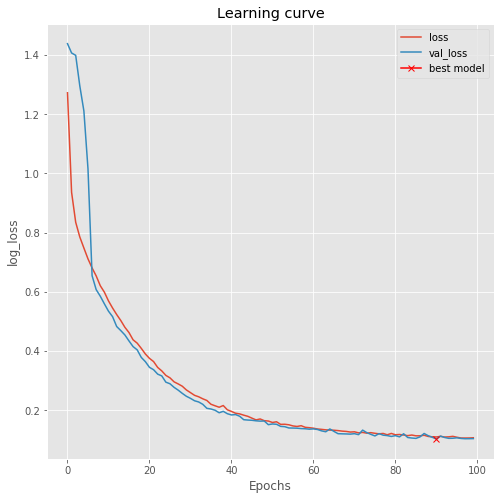

In [56]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

KeyError: 'acc'

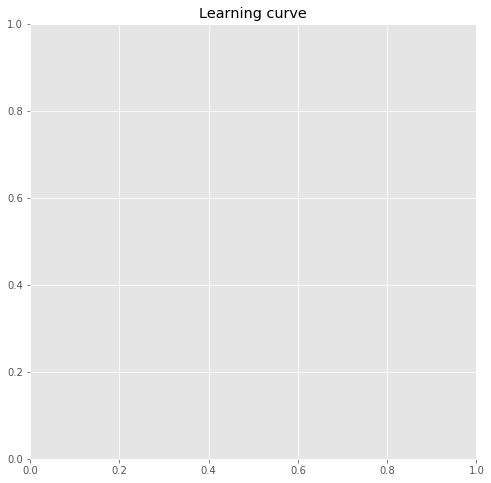

In [57]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["acc"], label="accuracy")
plt.plot(results.history["val_acc"], label="val_accuracy")
plt.plot( np.argmax(results.history["val_acc"]), np.max(results.history["val_acc"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_acc")
plt.legend();

In [13]:
# Load best model
model.load_weights('model-Unetplus_01.h5')

In [14]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)


342/342 [==============================] - ETA: 25 - ETA: 12 - ETA: 7 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 13ms/step


[0.11687391987669538, 0.9211366176605225]

In [23]:
model.save("UNETmodel.h5")

In [16]:
from keras.models import model_from_json
model_json = model.to_json()

In [19]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_val_t = (preds_val > 0.5).astype(np.float32)

342/342 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 4ms/step


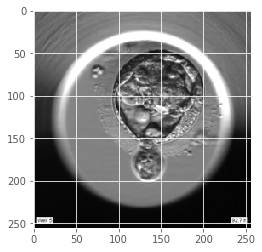

In [25]:
import matplotlib.image as mpimg
img_path = 'C:/Users/yousu/Downloads/BlastsOnline/001_ChKrGPS1.png'
img=mpimg.imread(img_path)
plt.imshow(img)

In [35]:
x = img_to_array(img)
x = resize(x, (256, 256, 1), mode='constant', preserve_range=True)
x = np.expand_dims(x, axis=0)
x = x / 255
x.shape

(1, 256, 256, 1)

In [36]:
# Predict on train, val and test
preds_val = model.predict(x, verbose=1)

# Threshold predictions
preds_val_t = (preds_val > 0.5).astype(np.float32)

1/1 [==============================] - 0s 269ms/step


In [38]:
final_conv_layer = model.get_layer('conv2d_19')

In [39]:
        get_output = K.function([model.layers[0].input], \
                    [final_conv_layer.output, 
        model.layers[-1].output])

In [40]:
[conv_outputs, predictions] = get_output([x])

In [41]:
conv_outputs = conv_outputs[0, :, :, :]

In [44]:
class_weights = model.layers[-1].get_weights()[0]

In [54]:
conv_outputs.shape

(256, 256, 1)

In [70]:
class_weights[:,0].shape

(1, 16, 1)

In [72]:
cam.shape

(256, 1)

In [74]:
argmax = np.argmax(preds_val_t[0])

In [75]:
output = model.output[:, argmax]

In [76]:
grads = K.gradients(output, final_conv_layer.output)[0]

In [77]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))

In [78]:
iterate = K.function([model.input], [pooled_grads, final_conv_layer.output[0]])

In [79]:
pooled_grads_value, conv_layer_output_value = iterate([x])

In [82]:
conv_layer_output_value.shape

(256, 256, 1)

In [87]:
grads.shape

TensorShape([Dimension(None), Dimension(256), Dimension(256), Dimension(1)])

In [86]:
#for i in range(256):
i=1
conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

IndexError: index 1 is out of bounds for axis 2 with size 1

In [89]:
        #Create the class activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
        target_class = 0
        for i, w in enumerate(class_weights[:, target_class]):
                cam += w * conv_outputs[i, :, :]

ValueError: operands could not be broadcast together with shapes (16,1) (256,1) 

In [ ]:
    def visualize_class_activation_map(model_path, img_path, output_path):
        #model = load_model(model_path)
        model = model_path
        original_img = cv2.imread(img_path, 1)
        width, height, _ = original_img.shape

        #Reshape to the network input shape (3, w, h).
        img = np.array([np.transpose(np.float32(original_img), (2, 0, 1))])
        
        #Get the 512 input weights to the softmax.
        class_weights = model.layers[-1].get_weights()[0]
        final_conv_layer = get_output_layer(model, "conv5_3")
        get_output = K.function([model.layers[0].input], \
                    [final_conv_layer.output, 
        model.layers[-1].output])
        [conv_outputs, predictions] = get_output([img])
        conv_outputs = conv_outputs[0, :, :, :]

        #Create the class activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
        target_class = 1
        for i, w in enumerate(class_weights[:, target_class]):
                cam += w * conv_outputs[i, :, :]

In [21]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='r', levels=[0.7])
    ax[0].set_title('Embryo')
    ax[0].grid(False)

    ax[1].imshow(y[ix].squeeze(), interpolation='bilinear', cmap='gray')
    ax[1].set_title('Embryo_GT')
    ax[1].grid(False)

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='r', levels=[0.7])
    ax[2].set_title('Embryo Predicted')
    ax[2].grid(False)
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='r', levels=[0.7])
    ax[3].set_title('Embryo Predicted binary');
    ax[3].grid(False)

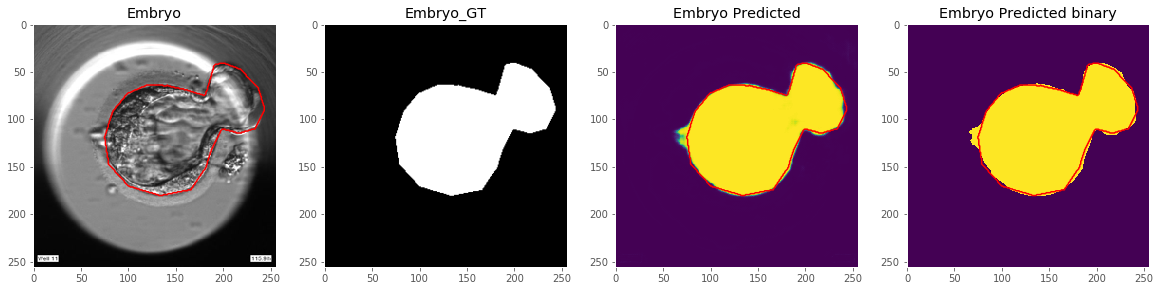

In [22]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=66)

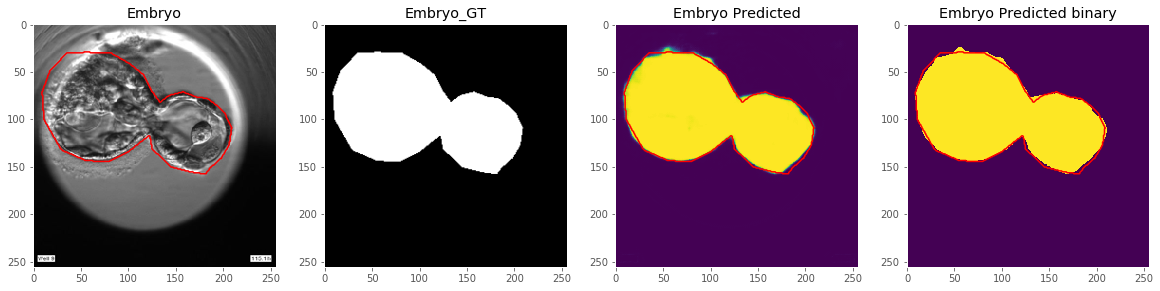

In [23]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=34)

In [24]:
import cv2
from PIL import Image
import imageio

for x in range (len(X_valid)):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(X_valid[x, ...,0],cmap='gray')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.savefig('Original' + '_' + str(x+1) + '.png')
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(preds_val_t[x].squeeze(), vmin=0, vmax=1)
    ax.contour(y_valid[x].squeeze(), colors='r', levels=[0.8])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.savefig('Predicted' + '_' + str(x+1) + '.png')
    
    image1 = Image.open('Original' + '_' + str(x+1) + '.png')
    image2 = Image.open('Predicted' + '_' + str(x+1) + '.png')
    image1 = image1.resize((500,500), Image.NEAREST)
    image2 = image2.resize((500,500), Image.NEAREST)
    alphaBlended1 = Image.blend(image1, image2, alpha=0.7)
    imageio.imwrite('Overlay' + '_' + str(x+1) + '.png', alphaBlended1)

ImportError: No module named 'cv2'

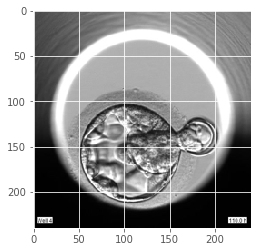

True

In [54]:
import cv2
f_image = X_train[114]
f_image = np.array(first_image)
pixels = first_image.reshape((im_width, im_height))
plt.imshow(pixels, cmap='gray')
plt.show()
cv2.imshow('image',f_image)
cv2.imwrite('messigray.png',f_image)

In [15]:
from keras import backend as K

def accuracy(y_true, y_pred):
     #test accuracy
     y_pred_pos = K.round(K.clip(y_pred, 0, 1))
     y_pred_neg = 1 - y_pred_pos
 
 
     y_pos = K.round(K.clip(y_true, 0, 1))
     y_neg = 1 - y_pos
 
 
     tp = K.sum(y_pos * y_pred_pos)
     tn = K.sum(y_neg * y_pred_neg)
 
 
     fp = K.sum(y_neg * y_pred_pos)
     fn = K.sum(y_pos * y_pred_neg)
 
 
     numerator = (tp + tn)
     denominator = (tp+tn+fp+fn)
 
 
     return numerator / (denominator + K.epsilon())

In [16]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# fit the model
#history = model.fit(Xtrain, ytrain, validation_split=0.3, epochs=10, verbose=0)

# evaluate the model
y_valid = tf.convert_to_tensor(y_valid, np.float32)
preds_val_t = tf.convert_to_tensor(preds_val_t, np.float32)
#preds_val = tf.convert_to_tensor(preds_val, np.float32)

In [17]:
with tf.Session() as sess:
    print(sess.run(recall_m(y_valid,preds_val_t)))
    print(sess.run(precision_m(y_valid,preds_val_t)))
    print(sess.run(f1_m(y_valid,preds_val_t)))

0.9712638
0.96735144
0.96930355


In [18]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.layers.flatten(y_true)
    y_pred_f = tf.layers.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [19]:
def jaccard(y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true, np.float32)
    y_pred = tf.convert_to_tensor(y_pred, np.float32)
    epsilon = 1e-15
    #intersection = (y_pred * y_true).sum(dim=-2).sum(dim=-1)
    #union = y_true.sum(dim=-2).sum(dim=-1) + y_pred.sum(dim=-2).sum(dim=-1)
    y_true_f = tf.layers.flatten(y_true)
    y_pred_f = tf.layers.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f)+tf.reduce_sum(y_pred_f)

    return (tf.reduce_mean(intersection + epsilon)/ (union - intersection + epsilon))

In [20]:
from keras import backend as K

def specificity(y_true, y_pred):
     #test accuracy
     y_pred_pos = K.round(K.clip(y_pred, 0, 1))
     y_pred_neg = 1 - y_pred_pos
 
 
     y_pos = K.round(K.clip(y_true, 0, 1))
     y_neg = 1 - y_pos
 
 
     tp = K.sum(y_pos * y_pred_pos)
     tn = K.sum(y_neg * y_pred_neg)
 
 
     fp = K.sum(y_neg * y_pred_pos)
     fn = K.sum(y_pos * y_pred_neg)
 
 
     numerator = tn
     denominator = (tn+fp)
 
 
     return numerator / (denominator + K.epsilon())

In [21]:
with tf.Session() as sess:
    print(sess.run(dice_coef(y_valid,preds_val_t)))
    print(sess.run(jaccard(y_valid,preds_val_t)))
    print(sess.run(accuracy(y_valid,preds_val_t)))
    print(sess.run(specificity(y_valid, preds_val_t)))

Instructions for updating:
Use keras.layers.flatten instead.
0.96930367
0.94043577
0.98784715
0.9919297


In [18]:
def jaccard_distance(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)

In [48]:
ji = jaccard_distance(y_valid, preds_val_t,smooth=100)
with tf.Session() as sess:
    print(sess.run(ji))

3.2162135


In [ ]:
# reduce to 1d array
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
#y_valid = y_valid[:,0,0]
#preds_val_t = preds_val_t[:,0,0]
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_valid, preds_val_t)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_valid, preds_val_t)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_valid, preds_val_t)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_valid, preds_val_t)
print('F1 score: %f' % f1)
JI = sklearn.metrics.jaccard_similarity_score(y_valid, preds_val_t)
print('Jaccard index: %f' % JI)

In [19]:
def iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [20]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou(y_valid, np.int32(preds_val > threshold)) for threshold in tqdm_notebook(thresholds)])

In [21]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

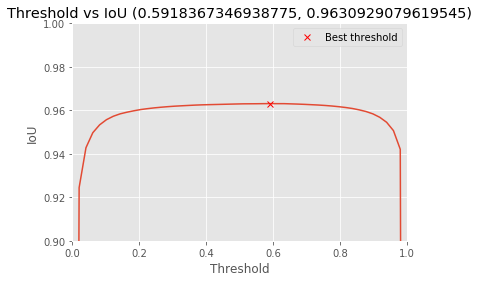

In [23]:
plt.plot(thresholds, ious)
plt.axis([0.0, 1.0, 0.9, 1.0])
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()